In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Para lidar com NaN, se necessário
import re # Para extração de padrões em strings
from datetime import datetime # Para manipulação de datas

# Configurações de exibição do pandas para não truncar o conteúdo
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("Bibliotecas importadas e configurações aplicadas!")

In [ ]:
file_path_order = 'Order_semicolon.csv'
file_path_campaign_queue = 'CampaignQueue_semicolon.csv'
file_path_campaign = 'Campaign_semicolon.csv'

# Carregar os arquivos CSV em DataFrames
try:
    df_order = pd.read_csv(file_path_order, sep=';')
    df_campaign_queue = pd.read_csv(file_path_campaign_queue, sep=';')
    df_campaign = pd.read_csv(file_path_campaign, sep=';')

    print("Arquivos carregados com sucesso!")
    print(f"df_order: {df_order.shape[0]} linhas, {df_order.shape[1]} colunas")
    print(f"df_campaign_queue: {df_campaign_queue.shape[0]} linhas, {df_campaign_queue.shape[1]} colunas")
    print(f"df_campaign: {df_campaign.shape[0]} linhas, {df_campaign.shape[1]} colunas")

except FileNotFoundError:
    print("Erro: Um ou mais arquivos não foram encontrados. Por favor, verifique os caminhos dos arquivos.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar os arquivos: {e}")


In [ ]:
print("--- Visualização Inicial: df_order ---")
print("\nPrimeiras 5 linhas:")
print(df_order.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_order.info()

print("\nEstatísticas descritivas básicas:")
print(df_order.describe(include='all'))

In [ ]:
print("--- Visualização Inicial: df_campaign_queue ---")
print("\nPrimeiras 5 linhas:")
print(df_campaign_queue.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_campaign_queue.info()

print("\nEstatísticas descritivas básicas:")
print(df_campaign_queue.describe(include='all'))

In [ ]:
print("--- Visualização Inicial: df_campaign ---")
print("\nPrimeiras 5 linhas:")
print(df_campaign.head())

print("\nInformações sobre as colunas e tipos de dados:")
df_campaign.info()

print("\nEstatísticas descritivas básicas:")
print(df_campaign.describe(include='all'))

In [16]:
def convert_date_column(df, column_name):
    original_type = df[column_name].dtype
    print(f"Iniciando conversão para a coluna '{column_name}' (Tipo original: {original_type})...")

    # Primeiro, tenta converter para numérico para identificar números de série do Excel
    numeric_dates = pd.to_numeric(df[column_name], errors='coerce')

    # Identifica quais são números de série válidos
    excel_serial_mask = numeric_dates.notna() & (numeric_dates > 1) # Números de série são maiores que 1

    # Converte números de série do Excel para datetime
    # 24 * 60 * 60 * 1000000000 para converter para nanosegundos para o pandas Timedelta
    df.loc[excel_serial_mask, column_name] = pd.to_datetime(numeric_dates[excel_serial_mask], unit='D', origin='1899-12-30')

    # Para os valores que não foram números de série, tenta converter diretamente para datetime
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce', dayfirst=True)

    print(f"Conversão concluída para a coluna '{column_name}'. Novos NaT's: {df[column_name].isna().sum()}")
    return df

# Aplicar a função às colunas de data relevantes em df_order
date_columns_order = ['createdAt', 'updatedAt']

for col in date_columns_order:
    if col in df_order.columns:
        df_order = convert_date_column(df_order, col)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada em df_order.")

# Verificar e converter 'totalAmount' para numérico
if 'totalAmount' in df_order.columns:
    df_order['totalAmount'] = pd.to_numeric(df_order['totalAmount'], errors='coerce')
    print(f"\nColuna 'totalAmount' convertida para numérica. Valores nulos após conversão: {df_order['totalAmount'].isna().sum()}")
else:
    print("\nAviso: Coluna 'totalAmount' não encontrada em df_order. Verifique o nome da coluna de valor dos pedidos.")

print("\nVerificação dos tipos de dados de df_order após o tratamento:")
df_order.info()
print("\nPrimeiras linhas de df_order após o tratamento das datas:")
print(df_order.head())

Iniciando conversão para a coluna 'createdAt' (Tipo original: object)...
Conversão concluída para a coluna 'createdAt'. Novos NaT's: 0
Iniciando conversão para a coluna 'updatedAt' (Tipo original: object)...
Conversão concluída para a coluna 'updatedAt'. Novos NaT's: 0

Coluna 'totalAmount' convertida para numérica. Valores nulos após conversão: 0

Verificação dos tipos de dados de df_order após o tratamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    2000 non-null   int64         
 1   companyId             2000 non-null   object        
 2   containerId           2000 non-null   object        
 3   createdAt             2000 non-null   datetime64[ns]
 4   customer              2000 non-null   int64         
 5   displayId             2000 non-null   object        
 6   engineId   

In [17]:
# Remover linhas com valores nulos em 'createdAt' após a conversão, pois são essenciais para a análise temporal
initial_rows = df_order.shape[0]
df_order.dropna(subset=['createdAt'], inplace=True)
print(f"Linhas removidas devido a valores nulos em 'createdAt': {initial_rows - df_order.shape[0]}")

# Extrair o dia da semana e a hora do dia
df_order['hour_of_day'] = df_order['createdAt'].dt.hour
df_order['day_of_week'] = df_order['createdAt'].dt.day_name() # Nome do dia da semana

# Mapear os dias da semana para português para melhor visualização (opcional)
day_mapping = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df_order['day_of_week'] = df_order['day_of_week'].map(day_mapping)

print("\nNovas colunas 'hour_of_day' e 'day_of_week' adicionadas a df_order.")
print("Primeiras linhas de df_order com as novas features:")
print(df_order[['createdAt', 'hour_of_day', 'day_of_week']].head())

Linhas removidas devido a valores nulos em 'createdAt': 0

Novas colunas 'hour_of_day' e 'day_of_week' adicionadas a df_order.
Primeiras linhas de df_order com as novas features:
            createdAt  hour_of_day    day_of_week
0 2025-01-08 15:47:00           15   Quarta-feira
1 2024-11-03 22:30:00           22        Domingo
2 2024-09-09 05:49:00            5  Segunda-feira
3 2025-05-22 06:22:00            6   Quinta-feira
4 2025-02-22 01:23:00            1         Sábado


In [ ]:
# Aplicar a função às colunas de data relevantes em df_campaign_queue
date_columns_campaign_queue = ['scheduledAt', 'sendAt', 'createdAt', 'updatedAt']

for col in date_columns_campaign_queue:
    if col in df_campaign_queue.columns:
        df_campaign_queue = convert_date_column(df_campaign_queue, col)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada em df_campaign_queue.")

# Verificação dos tipos de dados de df_campaign_queue após o tratamento
print("\nVerificação dos tipos de dados de df_campaign_queue após o tratamento:")
df_campaign_queue.info()
print("\nPrimeiras linhas de df_campaign_queue após o tratamento das datas:")
print(df_campaign_queue[date_columns_campaign_queue].head())

--- Análise de Picos de Pedidos por Hora do Dia ---

Número de pedidos por hora:
    hour_of_day  order_count
0             0           80
1             1           86
2             2           83
3             3           85
4             4           92
5             5           87
6             6          101
7             7           72
8             8           81
9             9           77
10           10           74
11           11           61
12           12           83
13           13           94
14           14           98
15           15           90
16           16           79
17           17           69
18           18           74
19           19           91
20           20           88
21           21           84
22           22           79
23           23           92

A hora com mais pedidos é a **6h**, com **101 pedidos**.


/tmp/ipython-input-3498672319.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_of_day', y='order_count', data=orders_by_hour, palette='viridis')


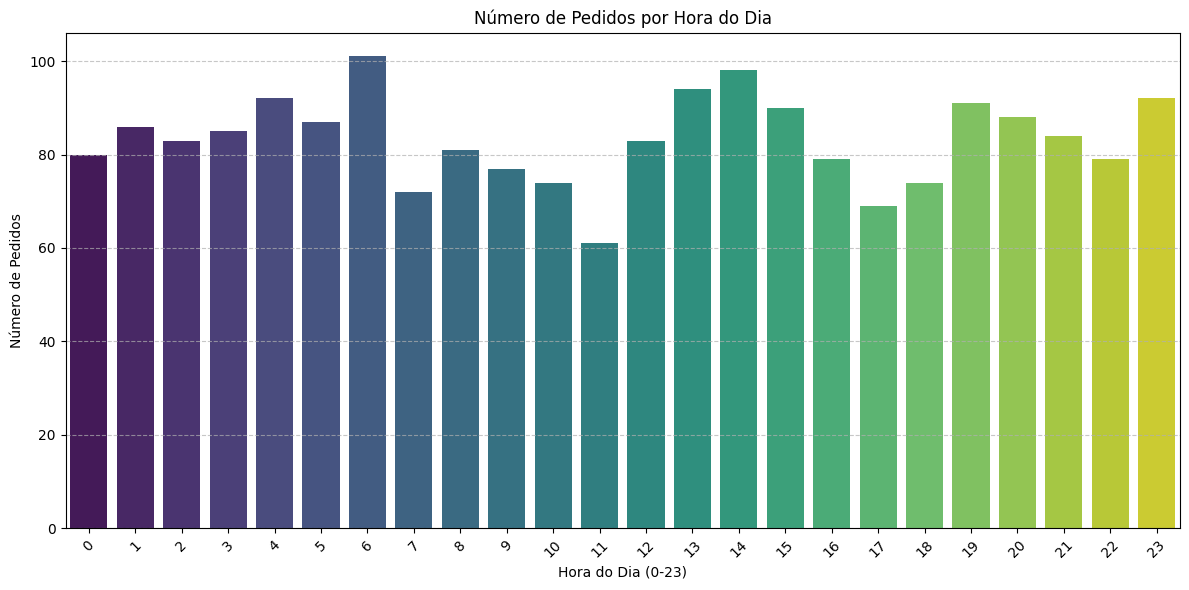

In [20]:
# Contar o número de pedidos por hora do dia
orders_by_hour = df_order.groupby('hour_of_day').size().reset_index(name='order_count')

# Encontrar a hora com o maior número de pedidos
peak_hour_info = orders_by_hour.loc[orders_by_hour['order_count'].idxmax()]
peak_hour = peak_hour_info['hour_of_day']
peak_count = peak_hour_info['order_count']

print("--- Análise de Picos de Pedidos por Hora do Dia ---")
print("\nNúmero de pedidos por hora:")
print(orders_by_hour)

print(f"\nA hora com mais pedidos é a **{int(peak_hour)}h**, com **{int(peak_count)} pedidos**.")

# Visualização dos pedidos por hora do dia
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='order_count', data=orders_by_hour, palette='viridis')
plt.title('Número de Pedidos por Hora do Dia')
plt.xlabel('Hora do Dia (0-23)')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Análise de Picos de Pedidos por Dia da Semana ---

Número de pedidos por dia da semana:
     day_of_week  order_count
0  Segunda-feira          295
1    Terça-feira          297
2   Quarta-feira          287
3   Quinta-feira          265
4    Sexta-feira          272
5         Sábado          273
6        Domingo          311

O dia da semana com mais pedidos é **Domingo**, com **311 pedidos**.


/tmp/ipython-input-1113111387.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='order_count', data=orders_by_day, order=day_order, palette='mako')


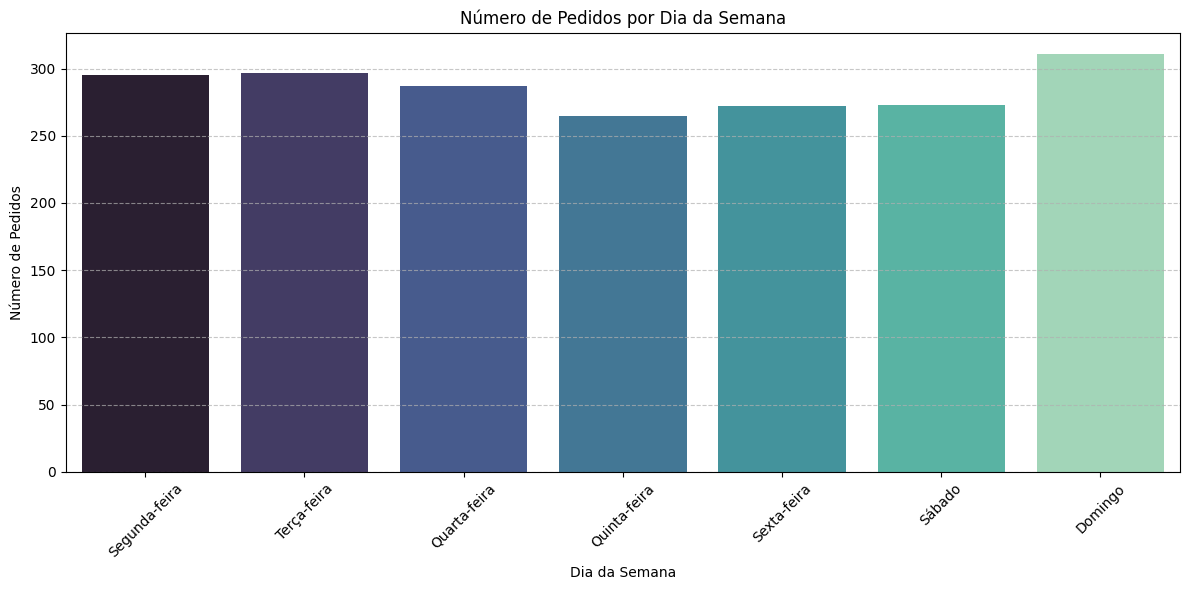

In [21]:
# Definir a ordem dos dias da semana para o gráfico
day_order = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

# Contar o número de pedidos por dia da semana
orders_by_day = df_order.groupby('day_of_week').size().reindex(day_order).reset_index(name='order_count')

# Encontrar o dia com o maior número de pedidos
peak_day_info = orders_by_day.loc[orders_by_day['order_count'].idxmax()]
peak_day = peak_day_info['day_of_week']
peak_day_count = peak_day_info['order_count']

print("--- Análise de Picos de Pedidos por Dia da Semana ---")
print("\nNúmero de pedidos por dia da semana:")
print(orders_by_day)

print(f"\nO dia da semana com mais pedidos é **{peak_day}**, com **{int(peak_day_count)} pedidos**.")

# Visualização dos pedidos por dia da semana
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='order_count', data=orders_by_day, order=day_order, palette='mako')
plt.title('Número de Pedidos por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Análise de Picos de Pedidos por Dia da Semana e Hora do Dia ---

Top 10 dias da semana e horários com mais pedidos:
       day_of_week  hour_of_day  order_count
150    Terça-feira            6           25
135         Sábado           15           21
158    Terça-feira           14           20
78   Segunda-feira            6           20
1          Domingo            1           18
26    Quarta-feira            2           18
148    Terça-feira            4           18
38    Quarta-feira           14           17
92   Segunda-feira           20           17
88   Segunda-feira           16           17


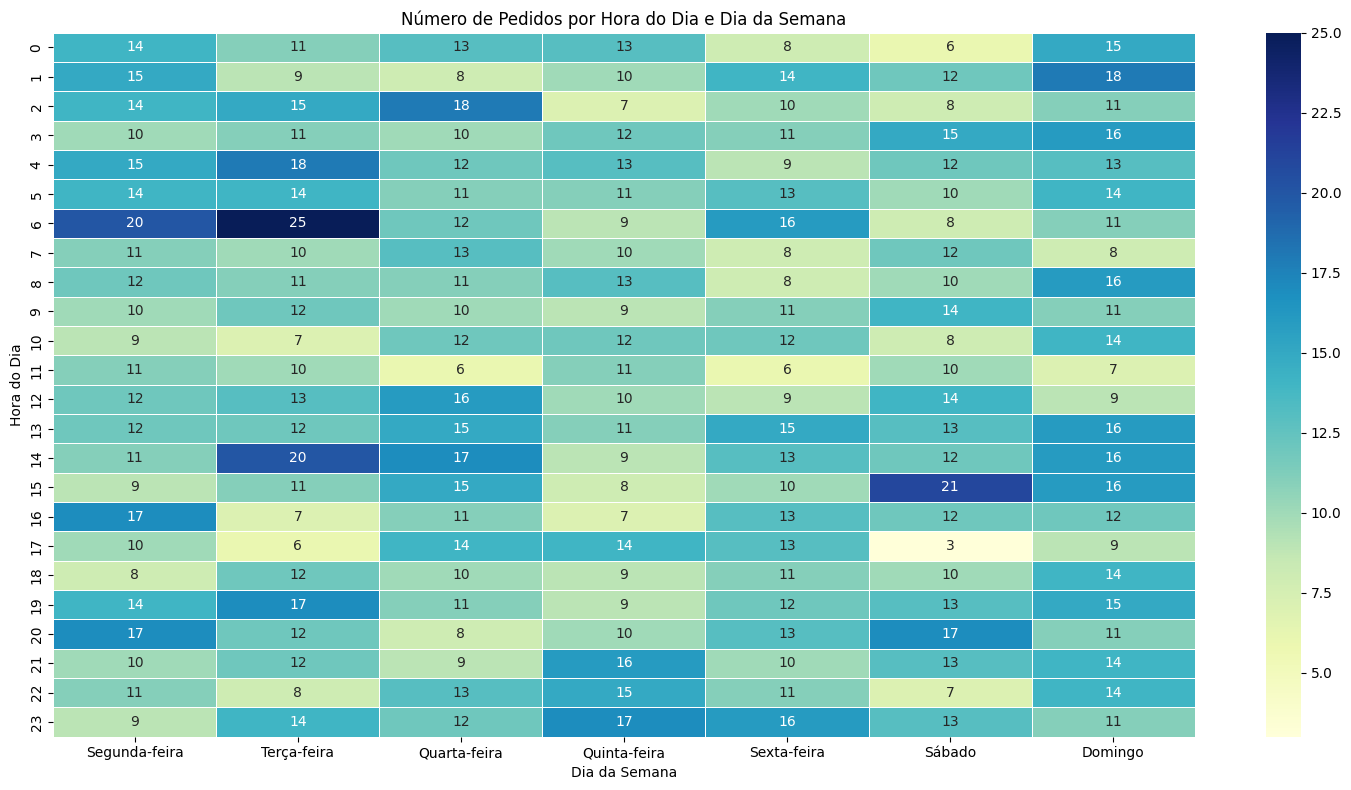

In [23]:
# Contar o número de pedidos por dia da semana e hora do dia
orders_by_day_hour = df_order.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='order_count')

# Ordenar por contagem de pedidos de forma descendente para ver os maiores picos
top_peaks = orders_by_day_hour.sort_values(by='order_count', ascending=False).head(10)

print("--- Análise de Picos de Pedidos por Dia da Semana e Hora do Dia ---")
print("\nTop 10 dias da semana e horários com mais pedidos:")
print(top_peaks)

# Visualização dos pedidos por dia da semana e hora do dia (Heatmap)
plt.figure(figsize=(15, 8))
# Pivotar a tabela para o formato de heatmap
heatmap_data = orders_by_day_hour.pivot_table(index='hour_of_day', columns='day_of_week', values='order_count', fill_value=0)

# Reordenar as colunas (dias da semana) para a ordem correta
heatmap_data = heatmap_data[day_order]

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Número de Pedidos por Hora do Dia e Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Hora do Dia')
plt.tight_layout()
plt.show()

In [34]:
# Contar o número de pedidos para cada combinação de dia da semana e hora do dia
df_demand = df_order.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='order_count')

# Ordenar para facilitar a visualização e categorização
df_demand = df_demand.sort_values(by=['day_of_week', 'hour_of_day']).reset_index(drop=True)

# Reutilizamos df_demand_enriched da Célula 18 para garantir que temos as features adicionais
# Se você rodou a Célula 18, o df_demand_enriched já está pronto.
# Se não, vamos recriar o df_encoded_enriched para garantir a nova categorização.
# Criar um flag para "campanha agendada" e "campanha enviada" para cada combinação de (day_of_week, hour_of_day)
campaign_scheduled_hours = df_campaign_queue.groupby(['scheduled_day_of_week', 'scheduled_hour_of_day']).size().reset_index(name='num_campaigns_scheduled')
campaign_sent_hours = df_campaign_queue.groupby(['sent_day_of_week', 'sent_hour_of_day']).size().reset_index(name='num_campaigns_sent')

# Renomear as colunas para o merge
campaign_scheduled_hours.rename(columns={'scheduled_day_of_week': 'day_of_week', 'scheduled_hour_of_day': 'hour_of_day'}, inplace=True)
campaign_sent_hours.rename(columns={'sent_day_of_week': 'day_of_week', 'sent_hour_of_day': 'hour_of_day'}, inplace=True)

# Merge com df_demand original
df_demand_enriched = df_demand.merge(campaign_scheduled_hours, on=['day_of_week', 'hour_of_day'], how='left')
df_demand_enriched = df_demand_enriched.merge(campaign_sent_hours, on=['day_of_week', 'hour_of_day'], how='left')

# Preencher NaN com 0 onde não houve campanhas naquele slot de tempo
df_demand_enriched['num_campaigns_scheduled'] = df_demand_enriched['num_campaigns_scheduled'].fillna(0).astype(int)
df_demand_enriched['num_campaigns_sent'] = df_demand_enriched['num_campaigns_sent'].fillna(0).astype(int)

# Adicionar flag de fim de semana
df_demand_enriched['is_weekend'] = df_demand_enriched['day_of_week'].isin(['Sábado', 'Domingo']).astype(int)

print("--- Dataset de Demanda Preparado e Enriquecido ---")
print("Primeiras 5 linhas do df_demand_enriched:")
print(df_demand_enriched.head())
print(f"\nTotal de combinações (linhas) de dia/hora: {df_demand_enriched.shape[0]}")
print(f"Estatísticas descritivas da contagem de pedidos:\n{df_demand_enriched['order_count'].describe()}")

# --- Re-definindo as Categorias de Demanda (Pico vs. Normal) ---
# Vamos usar um limiar mais significativo.
# Uma opção é a média + 1 desvio padrão, ou um valor fixo baseado no negócio.
# Com base na describe(), a média é 17.5 e o desvio padrão é 4.08.
# Média + 1 Desvio Padrão = 17.5 + 4.08 = 21.58. Vamos arredondar para 22 pedidos.
# Ou podemos usar um quantile superior, por exemplo, o 75% quantile, que é 20.
# Para simplificar e ter um impacto mais claro na alocação, vamos usar a média + 1 desvio padrão.

peak_threshold = df_demand_enriched['order_count'].mean() + df_demand_enriched['order_count'].std()
print(f"\nLimiar para 'Pico' (Média + 1 Desvio Padrão): {peak_threshold:.2f} pedidos")

def categorize_demand_binary(count):
    if count >= peak_threshold:
        return 'Pico'
    else:
        return 'Normal'

df_demand_enriched['demand_category_binary'] = df_demand_enriched['order_count'].apply(categorize_demand_binary)

print(f"\nCategorias de demanda binárias definidas com base em:")
print(f"  - Pico: >= {peak_threshold:.2f} pedidos")
print(f"  - Normal: < {peak_threshold:.2f} pedidos")
print("\nDistribuição das categorias de demanda binárias:")
print(df_demand_enriched['demand_category_binary'].value_counts())

print("\nPrimeiras 5 linhas do df_demand_enriched com a nova categoria binária:")
print(df_demand_enriched.head())

--- Dataset de Demanda Preparado e Enriquecido ---
Primeiras 5 linhas do df_demand_enriched:
  day_of_week  hour_of_day  order_count  num_campaigns_scheduled  num_campaigns_sent  is_weekend
0     Domingo            0           15                       30                  15           1
1     Domingo            1           18                       29                  23           1
2     Domingo            2           11                       25                  26           1
3     Domingo            3           16                       30                  17           1
4     Domingo            4           13                       28                  18           1

Total de combinações (linhas) de dia/hora: 168
Estatísticas descritivas da contagem de pedidos:
count    168.000000
mean      11.904762
std        3.233874
min        3.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       25.000000
Name: order_count, dtype: float64

Limiar para 'Pico' (Média + 1 Des

In [37]:
# Reordenar os dias da semana para garantir consistência no encoding, se necessário
day_order_for_encoding = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_demand_enriched['day_of_week'] = pd.Categorical(df_demand_enriched['day_of_week'], categories=day_order_for_encoding, ordered=True)

df_encoded_enriched = pd.get_dummies(df_demand_enriched, columns=['day_of_week'], drop_first=False)

print("--- Features Engenheiradas (One-Hot Encoding) ---")
print("Primeiras 5 linhas do DataFrame com features codificadas:")
print(df_encoded_enriched.head())

# --- Definição de X (features) e y (target) ---
# Features (X): 'hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent' e as colunas One-Hot Encoded dos dias da semana
X = df_encoded_enriched[['hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent'] + [col for col in df_encoded_enriched.columns if 'day_of_week_' in col]]
y = df_encoded_enriched['demand_category_binary'] # Nova variável alvo binária

print(f"\nFormato de X (features): {X.shape}")
print(f"Formato de y (target): {y.shape}")
print("\nPrimeiras 5 linhas de X:")
print(X.head())
print("\nPrimeiras 5 linhas de y:")
print(y.head())

--- Features Engenheiradas (One-Hot Encoding) ---
Primeiras 5 linhas do DataFrame com features codificadas:
   hour_of_day  order_count  num_campaigns_scheduled  num_campaigns_sent  is_weekend demand_category_binary  day_of_week_Segunda-feira  day_of_week_Terça-feira  day_of_week_Quarta-feira  day_of_week_Quinta-feira  day_of_week_Sexta-feira  day_of_week_Sábado  day_of_week_Domingo
0            0           15                       30                  15           1                 Normal                      False                    False                     False                     False                    False               False                 True
1            1           18                       29                  23           1                   Pico                      False                    False                     False                     False                    False               False                 True
2            2           11                       25      

In [38]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
# Stratify=y para garantir que a proporção de 'Normal' e 'Pico' seja a mesma em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Divisão dos Dados em Treino e Teste ---")
print(f"X_train (treino - features): {X_train.shape}")
print(f"y_train (treino - target): {y_train.shape}")
print(f"X_test (teste - features): {X_test.shape}")
print(f"y_test (teste - target): {y_test.shape}")

print("\nDistribuição das classes em y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição das classes em y_test:")
print(y_test.value_counts(normalize=True))

--- Divisão dos Dados em Treino e Teste ---
X_train (treino - features): (134, 11)
y_train (treino - target): (134,)
X_test (teste - features): (34, 11)
y_test (teste - target): (34,)

Distribuição das classes em y_train:
demand_category_binary
Normal    0.865672
Pico      0.134328
Name: proportion, dtype: float64

Distribuição das classes em y_test:
demand_category_binary
Normal    0.882353
Pico      0.117647
Name: proportion, dtype: float64


--- Treinamento e Avaliação: Árvore de Decisão ---
Resultados com a divisão original de Treino/Teste:

Acurácia da Árvore de Decisão: 0.3824

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.43      0.30      0.35        10
       Baixa       0.29      0.18      0.22        11
       Média       0.40      0.62      0.48        13

    accuracy                           0.38        34
   macro avg       0.37      0.37      0.35        34
weighted avg       0.37      0.38      0.36        34



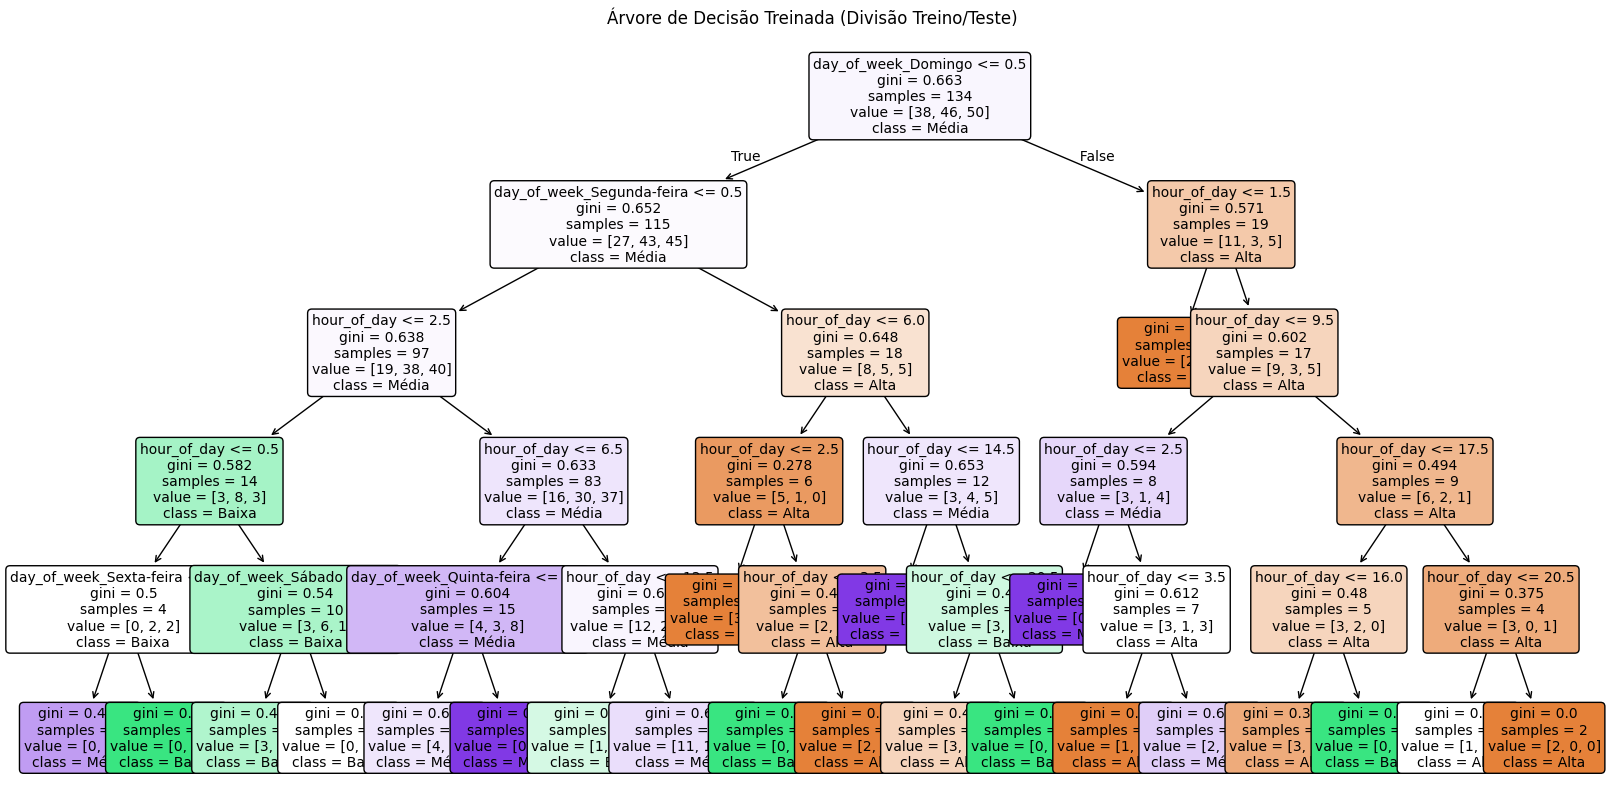

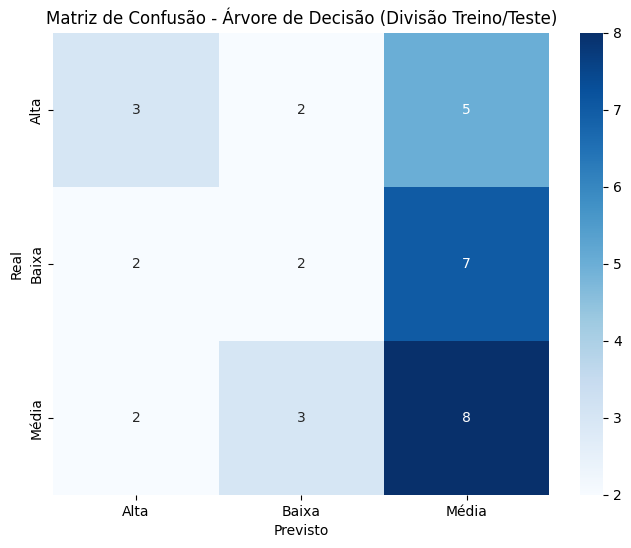


--- Validação Cruzada Stratified K-Fold (Árvore de Decisão) ---

Acurácia Média (CV): 0.3337 (+/- 0.0651)
F1-Score Ponderado Médio (CV): 0.3164 (+/- 0.0898)


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

print("--- Treinamento e Avaliação: Árvore de Decisão ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Inicializar o modelo de Árvore de Decisão
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5)

# Treinar o modelo
dt_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_dt = dt_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia da Árvore de Decisão: {accuracy_dt:.4f}")
print("\nRelatório de Classificação:")
print(report_dt)

# Visualização da Árvore de Decisão
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, feature_names=X.columns, class_names=dt_classifier.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Árvore de Decisão Treinada (Divisão Treino/Teste)')
plt.show()

# Matriz de Confusão para Árvore de Decisão
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=dt_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='g', cmap='Blues', xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão (Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Árvore de Decisão) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds é um valor comum

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(dt_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(dt_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

--- Treinamento e Avaliação: Regressão Logística ---
Resultados com a divisão original de Treino/Teste:

Acurácia da Regressão Logística: 0.2941

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.27      0.30      0.29        10
       Baixa       0.25      0.18      0.21        11
       Média       0.33      0.38      0.36        13

    accuracy                           0.29        34
   macro avg       0.29      0.29      0.28        34
weighted avg       0.29      0.29      0.29        34



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


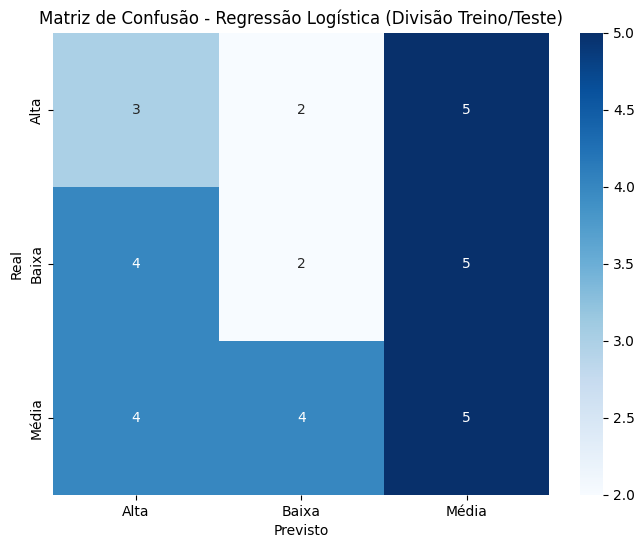


Coeficientes do Modelo de Regressão Logística para cada classe:

--- Coeficientes para a classe 'Alta' ---
day_of_week_Domingo          0.960474
day_of_week_Segunda-feira    0.524779
hour_of_day                 -0.018839
day_of_week_Terça-feira     -0.187365
day_of_week_Quarta-feira    -0.224520
day_of_week_Sábado          -0.402899
day_of_week_Sexta-feira     -0.406339
day_of_week_Quinta-feira    -0.919145
dtype: float64

--- Coeficientes para a classe 'Baixa' ---
day_of_week_Quinta-feira     0.487291
day_of_week_Sexta-feira      0.320110
hour_of_day                 -0.002053
day_of_week_Sábado          -0.027073
day_of_week_Terça-feira     -0.027157
day_of_week_Quarta-feira    -0.224474
day_of_week_Segunda-feira   -0.290268
day_of_week_Domingo         -0.801541
dtype: float64

--- Coeficientes para a classe 'Média' ---
day_of_week_Quarta-feira     0.256564
day_of_week_Sábado           0.199051
day_of_week_Quinta-feira     0.031942
day_of_week_Terça-feira      0.029063
hour_of_day   

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Regressão Logística ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Inicializar o modelo de Regressão Logística
lr_classifier = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto', max_iter=1000)

# Treinar o modelo
lr_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_lr = lr_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia da Regressão Logística: {accuracy_lr:.4f}")
print("\nRelatório de Classificação:")
print(report_lr)

# Matriz de Confusão para Regressão Logística
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=lr_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', xticklabels=lr_classifier.classes_, yticklabels=lr_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (Divisão Treino/Teste)')
plt.show()

# Interpretabilidade: Coeficientes do modelo (quanto cada feature influencia)
print("\nCoeficientes do Modelo de Regressão Logística para cada classe:")
for i, class_name in enumerate(lr_classifier.classes_):
    print(f"\n--- Coeficientes para a classe '{class_name}' ---")
    coefs = pd.Series(lr_classifier.coef_[i], index=X.columns)
    print(coefs.sort_values(ascending=False))

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Regressão Logística) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(lr_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(lr_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

--- Treinamento e Avaliação: Naive Bayes (GaussianNB) ---
Resultados com a divisão original de Treino/Teste:

Acurácia do Naive Bayes: 0.8529

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.85        34
   macro avg       0.44      0.48      0.46        34
weighted avg       0.78      0.85      0.81        34



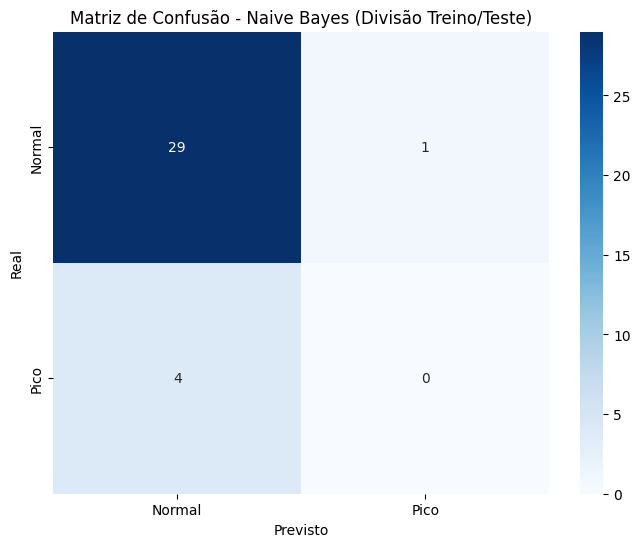


--- Validação Cruzada Stratified K-Fold (Naive Bayes) ---

Acurácia Média (CV): 0.7738 (+/- 0.0630)
F1-Score Ponderado Médio (CV): 0.7799 (+/- 0.0630)


In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Treinamento e Avaliação: Naive Bayes (GaussianNB) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Inicializar o modelo Naive Bayes
gnb_classifier = GaussianNB()

# Treinar o modelo
gnb_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_gnb = gnb_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
report_gnb = classification_report(y_test, y_pred_gnb)

print("Resultados com a divisão original de Treino/Teste:")
print(f"\nAcurácia do Naive Bayes: {accuracy_gnb:.4f}")
print("\nRelatório de Classificação:")
print(report_gnb)

# Matriz de Confusão para Naive Bayes
cm_gnb = confusion_matrix(y_test, y_pred_gnb, labels=gnb_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='g', cmap='Blues', xticklabels=gnb_classifier.classes_, yticklabels=gnb_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes (Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Naive Bayes) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
cv_scores_accuracy = cross_val_score(gnb_classifier, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(gnb_classifier, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

In [30]:
# Relembrando as colunas de df_campaign_queue
# print(df_campaign_queue.head())
# print(df_campaign_queue.info())

# O df_campaign_queue tem 'campaignId', 'storeId', 'scheduledAt', 'sendAt', 'status'

# 1. Merge de df_order com df_campaign para obter detalhes da campanha (se necessário)
# Por enquanto, df_campaign_queue já contém o suficiente para começar.
# Se precisarmos de 'name' ou 'description' da campanha, faríamos um merge adicional com df_campaign.

# 2. Vamos agregar informações sobre campanhas por loja e por período
# É complexo fazer um merge direto de data/hora, pois 'scheduledAt' e 'sendAt' são intervalos.
# Uma abordagem é criar um flag se *qualquer* campanha estava agendada/enviada em um determinado período (hora/dia).

# Vamos criar um DataFrame auxiliar para identificar horas/dias com campanhas
# Primeiro, extrair hora e dia da semana de scheduledAt e sendAt em df_campaign_queue
df_campaign_queue['scheduled_hour_of_day'] = df_campaign_queue['scheduledAt'].dt.hour
df_campaign_queue['scheduled_day_of_week'] = df_campaign_queue['scheduledAt'].dt.day_name().map(day_mapping) # Usar o mesmo mapeamento do df_order
df_campaign_queue['sent_hour_of_day'] = df_campaign_queue['sendAt'].dt.hour
df_campaign_queue['sent_day_of_week'] = df_campaign_queue['sendAt'].dt.day_name().map(day_mapping) # Usar o mesmo mapeamento do df_order

# Criar um flag para "campanha agendada" e "campanha enviada" para cada combinação de (day_of_week, hour_of_day)
campaign_scheduled_hours = df_campaign_queue.groupby(['scheduled_day_of_week', 'scheduled_hour_of_day']).size().reset_index(name='num_campaigns_scheduled')
campaign_sent_hours = df_campaign_queue.groupby(['sent_day_of_week', 'sent_hour_of_day']).size().reset_index(name='num_campaigns_sent')

# Renomear as colunas para o merge
campaign_scheduled_hours.rename(columns={'scheduled_day_of_week': 'day_of_week', 'scheduled_hour_of_day': 'hour_of_day'}, inplace=True)
campaign_sent_hours.rename(columns={'sent_day_of_week': 'day_of_week', 'sent_hour_of_day': 'hour_of_day'}, inplace=True)

# Merge com df_demand original
df_demand_enriched = df_demand.merge(campaign_scheduled_hours, on=['day_of_week', 'hour_of_day'], how='left')
df_demand_enriched = df_demand_enriched.merge(campaign_sent_hours, on=['day_of_week', 'hour_of_day'], how='left')

# Preencher NaN com 0 onde não houve campanhas naquele slot de tempo
df_demand_enriched['num_campaigns_scheduled'] = df_demand_enriched['num_campaigns_scheduled'].fillna(0).astype(int)
df_demand_enriched['num_campaigns_sent'] = df_demand_enriched['num_campaigns_sent'].fillna(0).astype(int)

# Adicionar flag de fim de semana
df_demand_enriched['is_weekend'] = df_demand_enriched['day_of_week'].isin(['Sábado', 'Domingo']).astype(int)

print("--- DataFrame de Demanda Enriquecido com Features de Campanhas e Fim de Semana ---")
print("Primeiras 5 linhas do df_demand_enriched:")
print(df_demand_enriched.head())
print("\nInformações sobre as novas colunas:")
print(df_demand_enriched[['num_campaigns_scheduled', 'num_campaigns_sent', 'is_weekend']].describe())


# --- Re-definição de X (features) e y (target) ---
# Features (X): 'hour_of_day', 'is_weekend' e as colunas One-Hot Encoded dos dias da semana, num_campaigns_scheduled, num_campaigns_sent
df_encoded_enriched = pd.get_dummies(df_demand_enriched, columns=['day_of_week'], drop_first=False)
X_enriched = df_encoded_enriched[['hour_of_day', 'is_weekend', 'num_campaigns_scheduled', 'num_campaigns_sent'] + [col for col in df_encoded_enriched.columns if 'day_of_week_' in col]]
y_enriched = df_encoded_enriched['demand_category']

print(f"\nFormato de X_enriched (features enriquecidas): {X_enriched.shape}")
print(f"Formato de y_enriched (target): {y_enriched.shape}")

# --- Re-divisão dos Dados em Treino e Teste com o dataset enriquecido ---
X_train_enriched, X_test_enriched, y_train_enriched, y_test_enriched = train_test_split(X_enriched, y_enriched, test_size=0.2, random_state=42, stratify=y_enriched)

print("\n--- Dados re-divididos em Treino e Teste com features enriquecidas ---")
print(f"X_train_enriched: {X_train_enriched.shape}")
print(f"X_test_enriched: {X_test_enriched.shape}")

--- DataFrame de Demanda Enriquecido com Features de Campanhas e Fim de Semana ---
Primeiras 5 linhas do df_demand_enriched:
  day_of_week  hour_of_day  order_count demand_category  num_campaigns_scheduled  num_campaigns_sent  is_weekend
0     Domingo            0           15            Alta                       30                  15           1
1     Domingo            1           18            Alta                       29                  23           1
2     Domingo            2           11           Média                       25                  26           1
3     Domingo            3           16            Alta                       30                  17           1
4     Domingo            4           13           Média                       28                  18           1

Informações sobre as novas colunas:
       num_campaigns_scheduled  num_campaigns_sent  is_weekend
count               168.000000          168.000000  168.000000
mean                 29.761905    

--- Treinamento e Avaliação: Árvore de Decisão (Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia da Árvore de Decisão: 0.2941

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.40      0.40      0.40        10
       Baixa       0.28      0.45      0.34        11
       Média       0.17      0.08      0.11        13

    accuracy                           0.29        34
   macro avg       0.28      0.31      0.28        34
weighted avg       0.27      0.29      0.27        34



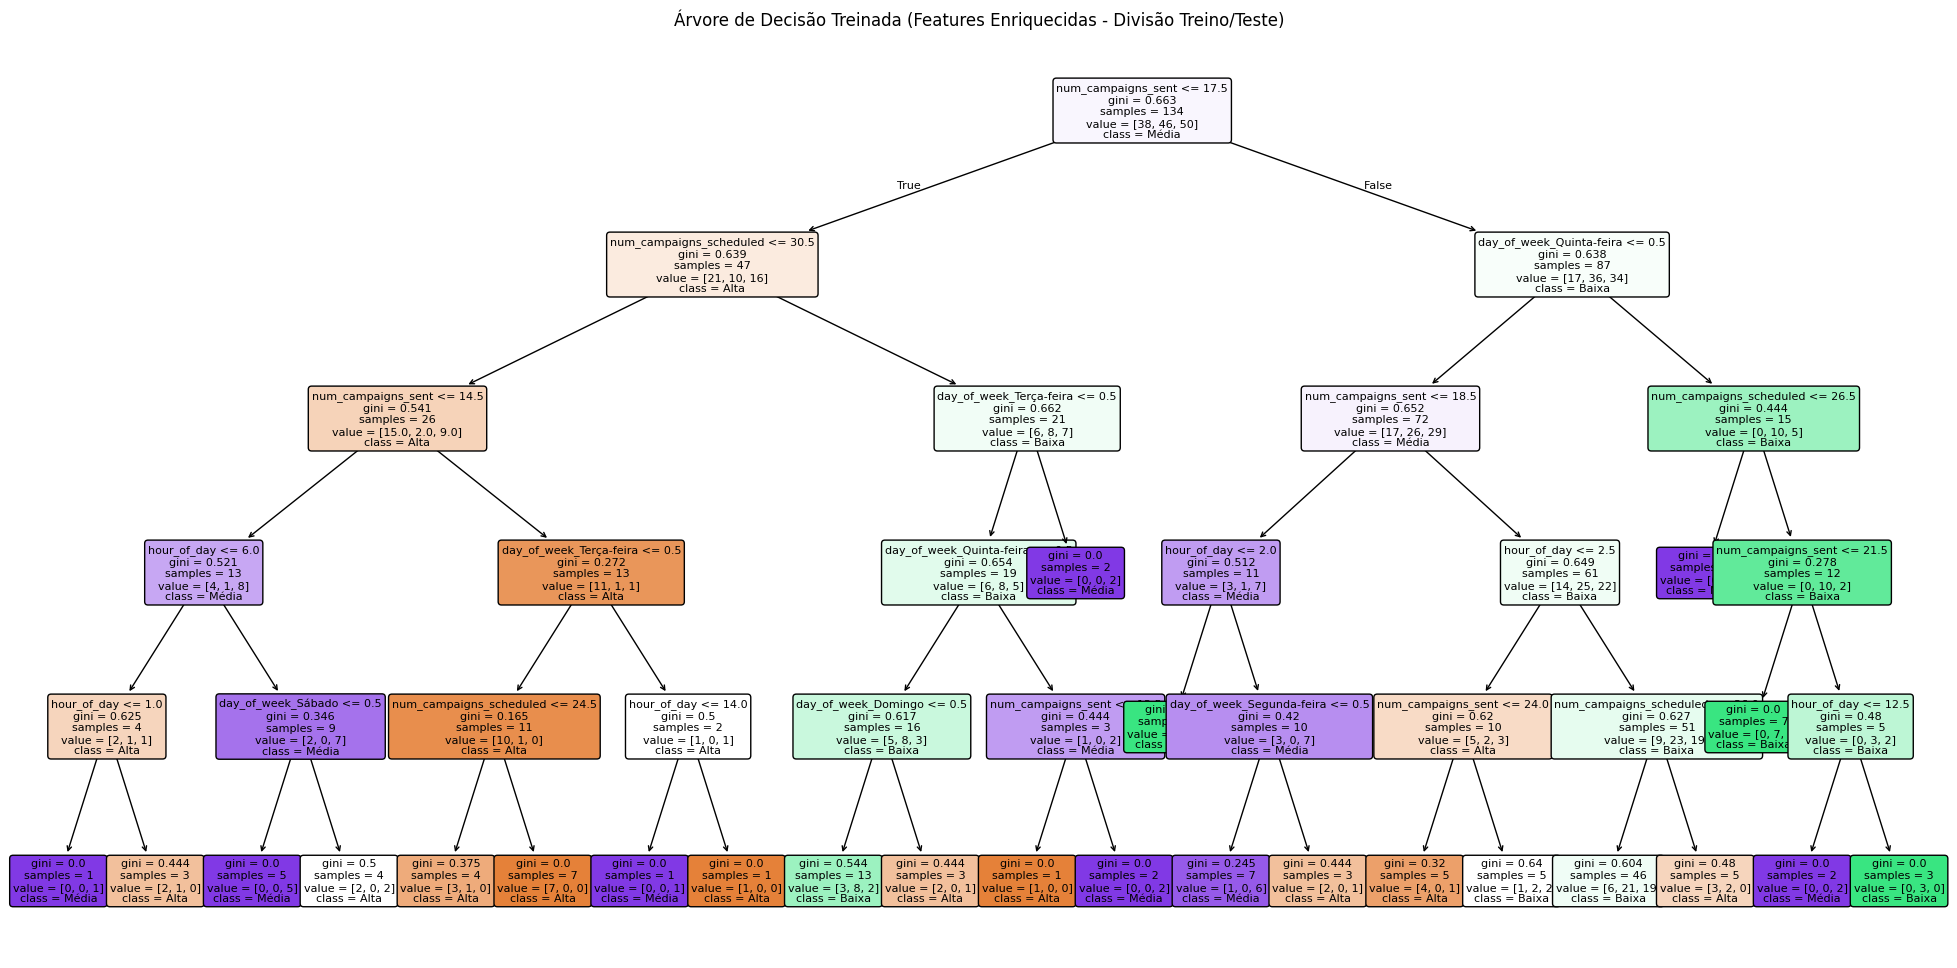

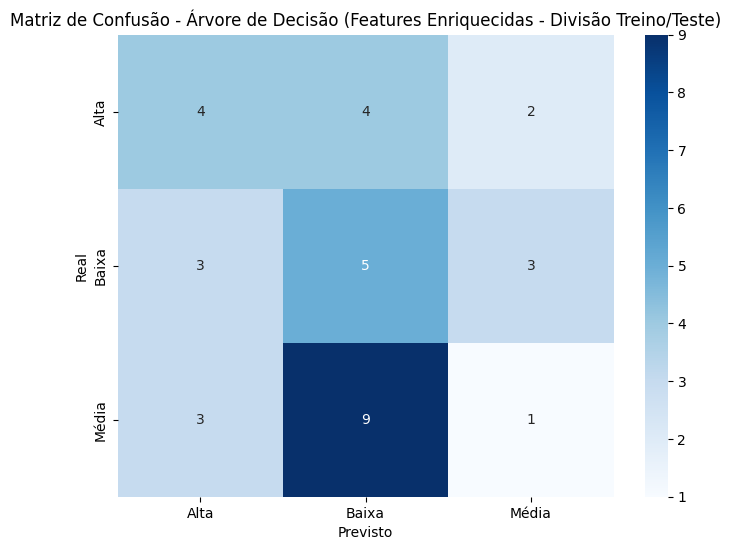


--- Validação Cruzada Stratified K-Fold (Árvore de Decisão - Features Enriquecidas) ---

Acurácia Média (CV): 0.3833 (+/- 0.2755)
F1-Score Ponderado Médio (CV): 0.3537 (+/- 0.2975)


In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

print("--- Treinamento e Avaliação: Árvore de Decisão (Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
dt_classifier_enriched = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_dt_enriched = dt_classifier_enriched.predict(X_test_enriched)

accuracy_dt_enriched = accuracy_score(y_test_enriched, y_pred_dt_enriched)
report_dt_enriched = classification_report(y_test_enriched, y_pred_dt_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia da Árvore de Decisão: {accuracy_dt_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_dt_enriched)

# Visualização da Árvore de Decisão (pode ser ainda maior)
plt.figure(figsize=(25, 12)) # Aumentei o tamanho para acomodar mais features
plot_tree(dt_classifier_enriched, feature_names=X_enriched.columns, class_names=dt_classifier_enriched.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Árvore de Decisão Treinada (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

cm_dt_enriched = confusion_matrix(y_test_enriched, y_pred_dt_enriched, labels=dt_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=dt_classifier_enriched.classes_, yticklabels=dt_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Árvore de Decisão - Features Enriquecidas) ---")
cv_enriched = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
cv_scores_accuracy_dt_enriched = cross_val_score(dt_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_dt_enriched = cross_val_score(dt_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_dt_enriched.mean():.4f} (+/- {cv_scores_accuracy_dt_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_dt_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_dt_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Regressão Logística (Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia da Regressão Logística: 0.2941

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.30      0.30      0.30        10
       Baixa       0.27      0.27      0.27        11
       Média       0.31      0.31      0.31        13

    accuracy                           0.29        34
   macro avg       0.29      0.29      0.29        34
weighted avg       0.29      0.29      0.29        34



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


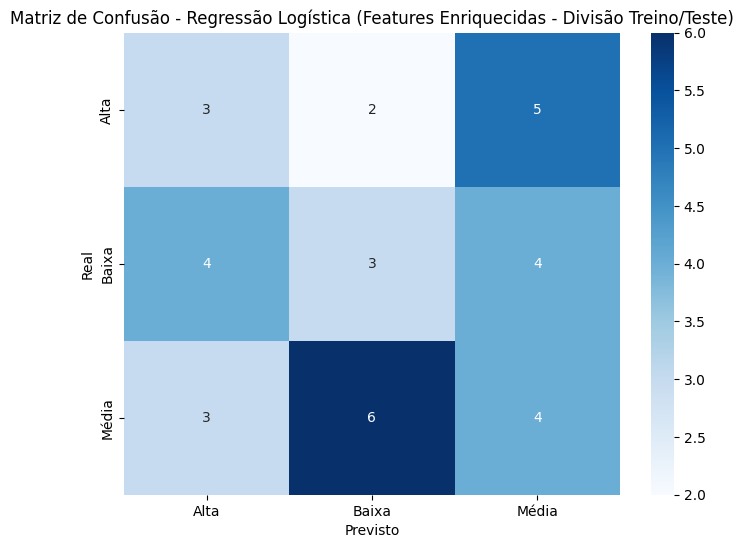


Coeficientes do Modelo de Regressão Logística para cada classe (Features Enriquecidas):

--- Coeficientes para a classe 'Alta' ---
day_of_week_Domingo          0.884150
day_of_week_Segunda-feira    0.665824
is_weekend                   0.357437
day_of_week_Terça-feira      0.112128
num_campaigns_scheduled      0.014106
hour_of_day                 -0.017154
day_of_week_Quarta-feira    -0.037872
num_campaigns_sent          -0.074819
day_of_week_Sexta-feira     -0.235024
day_of_week_Sábado          -0.526713
day_of_week_Quinta-feira    -0.763451
dtype: float64

--- Coeficientes para a classe 'Baixa' ---
day_of_week_Quinta-feira     0.277579
day_of_week_Sábado           0.151798
day_of_week_Sexta-feira      0.114967
num_campaigns_sent           0.046684
num_campaigns_scheduled      0.001564
hour_of_day                 -0.004040
day_of_week_Terça-feira     -0.306355
day_of_week_Segunda-feira   -0.429048
day_of_week_Quarta-feira    -0.440452
is_weekend                  -0.472919
day_of_week

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Regressão Logística (Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
lr_classifier_enriched = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto', max_iter=1000)
lr_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_lr_enriched = lr_classifier_enriched.predict(X_test_enriched)

accuracy_lr_enriched = accuracy_score(y_test_enriched, y_pred_lr_enriched)
report_lr_enriched = classification_report(y_test_enriched, y_pred_lr_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia da Regressão Logística: {accuracy_lr_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_lr_enriched)

cm_lr_enriched = confusion_matrix(y_test_enriched, y_pred_lr_enriched, labels=lr_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=lr_classifier_enriched.classes_, yticklabels=lr_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# Interpretabilidade: Coeficientes do modelo
print("\nCoeficientes do Modelo de Regressão Logística para cada classe (Features Enriquecidas):")
for i, class_name in enumerate(lr_classifier_enriched.classes_):
    print(f"\n--- Coeficientes para a classe '{class_name}' ---")
    coefs = pd.Series(lr_classifier_enriched.coef_[i], index=X_enriched.columns)
    print(coefs.sort_values(ascending=False))

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Regressão Logística - Features Enriquecidas) ---")
cv_scores_accuracy_lr_enriched = cross_val_score(lr_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_lr_enriched = cross_val_score(lr_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_lr_enriched.mean():.4f} (+/- {cv_scores_accuracy_lr_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_lr_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_lr_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Naive Bayes (GaussianNB - Features Enriquecidas) ---
Resultados com a divisão original de Treino/Teste (Enriquecido):

Acurácia do Naive Bayes: 0.2647

Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.27      0.30      0.29        10
       Baixa       0.18      0.18      0.18        11
       Média       0.33      0.31      0.32        13

    accuracy                           0.26        34
   macro avg       0.26      0.26      0.26        34
weighted avg       0.27      0.26      0.27        34



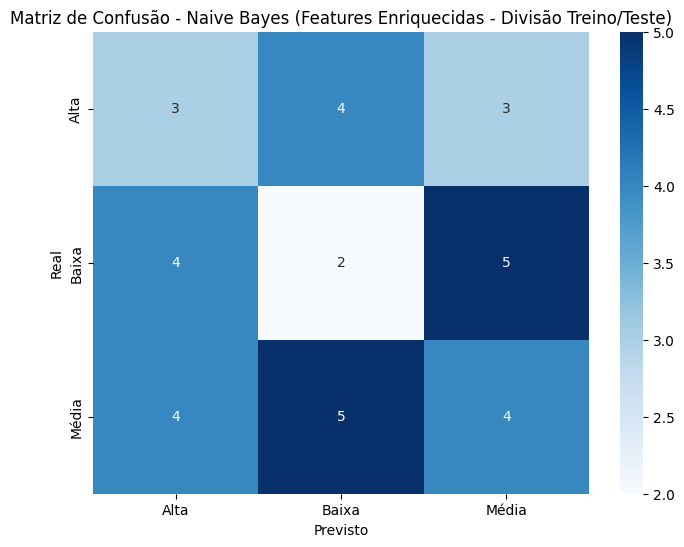


--- Validação Cruzada Stratified K-Fold (Naive Bayes - Features Enriquecidas) ---

Acurácia Média (CV): 0.3747 (+/- 0.1406)
F1-Score Ponderado Médio (CV): 0.3707 (+/- 0.1517)


In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Treinamento e Avaliação: Naive Bayes (GaussianNB - Features Enriquecidas) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
gnb_classifier_enriched = GaussianNB()
gnb_classifier_enriched.fit(X_train_enriched, y_train_enriched)
y_pred_gnb_enriched = gnb_classifier_enriched.predict(X_test_enriched)

accuracy_gnb_enriched = accuracy_score(y_test_enriched, y_pred_gnb_enriched)
report_gnb_enriched = classification_report(y_test_enriched, y_pred_gnb_enriched)

print("Resultados com a divisão original de Treino/Teste (Enriquecido):")
print(f"\nAcurácia do Naive Bayes: {accuracy_gnb_enriched:.4f}")
print("\nRelatório de Classificação:")
print(report_gnb_enriched)

cm_gnb_enriched = confusion_matrix(y_test_enriched, y_pred_gnb_enriched, labels=gnb_classifier_enriched.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb_enriched, annot=True, fmt='g', cmap='Blues', xticklabels=gnb_classifier_enriched.classes_, yticklabels=gnb_classifier_enriched.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes (Features Enriquecidas - Divisão Treino/Teste)')
plt.show()

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Naive Bayes - Features Enriquecidas) ---")
cv_scores_accuracy_gnb_enriched = cross_val_score(gnb_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='accuracy')
cv_scores_f1_weighted_gnb_enriched = cross_val_score(gnb_classifier_enriched, X_enriched, y_enriched, cv=cv_enriched, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy_gnb_enriched.mean():.4f} (+/- {cv_scores_accuracy_gnb_enriched.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted_gnb_enriched.mean():.4f} (+/- {cv_scores_f1_weighted_gnb_enriched.std() * 2:.4f})")

--- Treinamento e Avaliação: Random Forest Classifier (Balanceado, sem restrição de profundidade) ---
Resultados com a divisão original de Treino/Teste (Balanceado, sem restrição de profundidade):

Acurácia do Random Forest: 0.8824

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.94        30
        Pico       0.00      0.00      0.00         4

    accuracy                           0.88        34
   macro avg       0.44      0.50      0.47        34
weighted avg       0.78      0.88      0.83        34



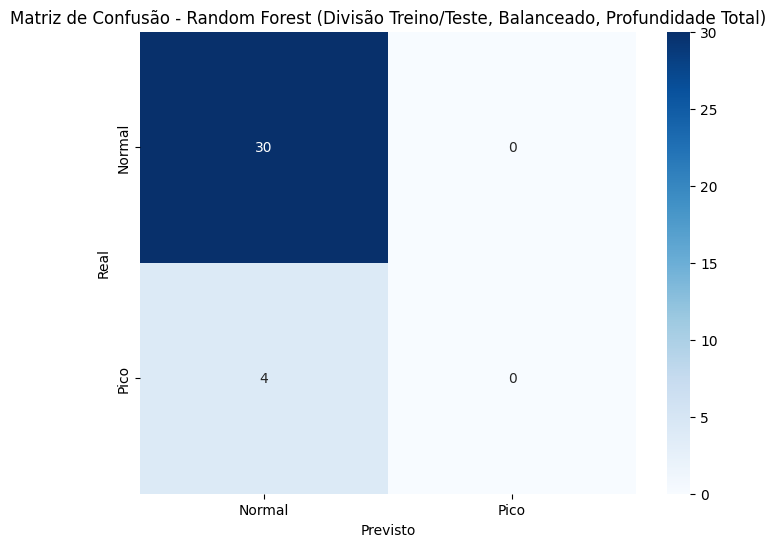


Importância das Features no Random Forest:
hour_of_day                  0.279901
num_campaigns_sent           0.252817
num_campaigns_scheduled      0.229002
day_of_week_Quinta-feira     0.040209
day_of_week_Domingo          0.033071
day_of_week_Quarta-feira     0.031566
is_weekend                   0.031561
day_of_week_Sexta-feira      0.027656
day_of_week_Terça-feira      0.027111
day_of_week_Segunda-feira    0.024176
day_of_week_Sábado           0.022929
dtype: float64

--- Validação Cruzada Stratified K-Fold (Random Forest, Balanceado, sem restrição de profundidade) ---

Acurácia Média (CV): 0.8456 (+/- 0.0657)
F1-Score Ponderado Médio (CV): 0.7963 (+/- 0.0502)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Treinamento e Avaliação: Random Forest Classifier (Balanceado, sem restrição de profundidade) ---")

# 1. Treinamento e avaliação com a divisão original de treino/teste
# Adicionado class_weight='balanced' e removido max_depth para permitir maior complexidade
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # max_depth=None por padrão

# Treinar o modelo
rf_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = rf_classifier.predict(X_test)

# Avaliar o desempenho do modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, zero_division=0) # zero_division=0 para evitar o UndefinedMetricWarning
                                                                       # e mostrar 0.0 explicitamente

print("Resultados com a divisão original de Treino/Teste (Balanceado, sem restrição de profundidade):")
print(f"\nAcurácia do Random Forest: {accuracy_rf:.4f}")
print("\nRelatório de Classificação:")
print(report_rf)

# Matriz de Confusão para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest (Divisão Treino/Teste, Balanceado, Profundidade Total)')
plt.show()

# Importância das Features (para interpretabilidade)
print("\nImportância das Features no Random Forest:")
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# 2. Validação Cruzada K-Fold
print("\n--- Validação Cruzada Stratified K-Fold (Random Forest, Balanceado, sem restrição de profundidade) ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliar o modelo usando validação cruzada
rf_classifier_cv = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # max_depth=None por padrão

cv_scores_accuracy = cross_val_score(rf_classifier_cv, X, y, cv=cv, scoring='accuracy')
cv_scores_f1_weighted = cross_val_score(rf_classifier_cv, X, y, cv=cv, scoring='f1_weighted')

print(f"\nAcurácia Média (CV): {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score Ponderado Médio (CV): {cv_scores_f1_weighted.mean():.4f} (+/- {cv_scores_f1_weighted.std() * 2:.4f})")

--- Previsão de Probabilidades e Análise de Threshold ---
Resultados do Conjunto de Teste com Probabilidades de 'Pico':
    Actual_Category  Predicted_Probability_Pico Predicted_Category_RF
103          Normal                        0.41                Normal
118          Normal                        0.33                Normal
69             Pico                        0.30                Normal
161          Normal                        0.29                Normal
86           Normal                        0.28                Normal
68           Normal                        0.24                Normal
2            Normal                        0.24                Normal
107          Normal                        0.24                Normal
156          Normal                        0.20                Normal
20           Normal                        0.15                Normal

Relatório de Classificação com Threshold Personalizado (0.1):
              precision    recall  f1-score   s

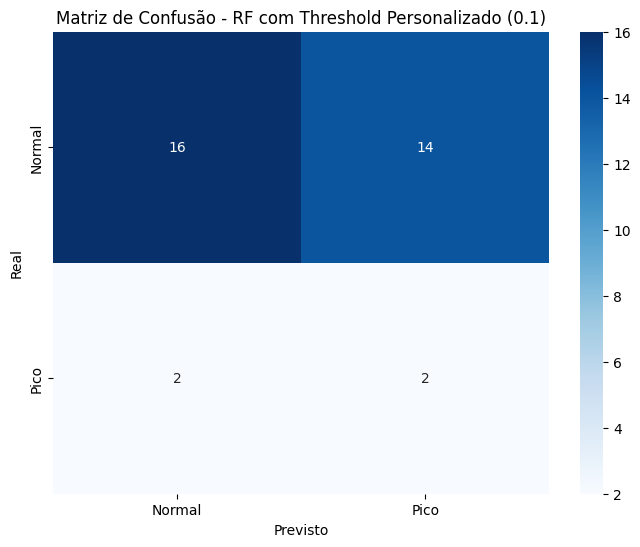


--- Considerações Finais ---
Com o volume atual de dados e a baixa representatividade da classe 'Pico', os modelos têm dificuldade em aprender e generalizar.
A análise de probabilidades, como feito acima, permite uma interpretação mais flexível, onde o limite para considerar um 'Pico' pode ser ajustado com base na tolerância a falsos positivos da operação.
No entanto, a coleta de mais dados ou uma redefinição clara do que constitui um 'Pico' são os caminhos mais promissores para um modelo preditivo mais eficaz.


In [42]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("--- Previsão de Probabilidades e Análise de Threshold ---")

# Reutilizar o rf_classifier já treinado (Balanceado, sem restrição de profundidade)
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# rf_classifier.fit(X_train, y_train) # Assegura que está treinado, mas já deveria estar

# Obter as probabilidades para cada classe no conjunto de teste
# O predict_proba retorna as probabilidades para todas as classes.
# Precisamos identificar a coluna correspondente à classe 'Pico'.
if 'Pico' in rf_classifier.classes_:
    pico_class_index = list(rf_classifier.classes_).index('Pico')
    probabilities = rf_classifier.predict_proba(X_test)[:, pico_class_index]
else:
    print("A classe 'Pico' não foi encontrada nas classes do modelo. Verifique a categorização.")
    probabilities = np.array([]) # array vazio para evitar erros

# Criar um DataFrame para visualizar as previsões de probabilidade
results_df = pd.DataFrame({
    'Actual_Category': y_test,
    'Predicted_Probability_Pico': probabilities,
    'Predicted_Category_RF': y_pred_rf # Previsão rígida anterior
}, index=X_test.index)

# Exibir os resultados, ordenando pelas maiores probabilidades de 'Pico'
print("Resultados do Conjunto de Teste com Probabilidades de 'Pico':")
print(results_df.sort_values(by='Predicted_Probability_Pico', ascending=False).head(10))

# Análise de um threshold diferente:
# Por exemplo, se quisermos ser mais agressivos e considerar "Pico" se a probabilidade for maior que 0.1
custom_threshold = 0.1
results_df['Predicted_Category_Custom_Threshold'] = np.where(results_df['Predicted_Probability_Pico'] >= custom_threshold, 'Pico', 'Normal')

print(f"\nRelatório de Classificação com Threshold Personalizado ({custom_threshold}):")
print(classification_report(results_df['Actual_Category'], results_df['Predicted_Category_Custom_Threshold'], zero_division=0))

cm_custom_threshold = confusion_matrix(results_df['Actual_Category'], results_df['Predicted_Category_Custom_Threshold'], labels=rf_classifier.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom_threshold, annot=True, fmt='g', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - RF com Threshold Personalizado ({custom_threshold})')
plt.show()

print("\n--- Considerações Finais ---")
print("Com o volume atual de dados e a baixa representatividade da classe 'Pico', os modelos têm dificuldade em aprender e generalizar.")
print("A análise de probabilidades, como feito acima, permite uma interpretação mais flexível, onde o limite para considerar um 'Pico' pode ser ajustado com base na tolerância a falsos positivos da operação.")
print("No entanto, a coleta de mais dados ou uma redefinição clara do que constitui um 'Pico' são os caminhos mais promissores para um modelo preditivo mais eficaz.")


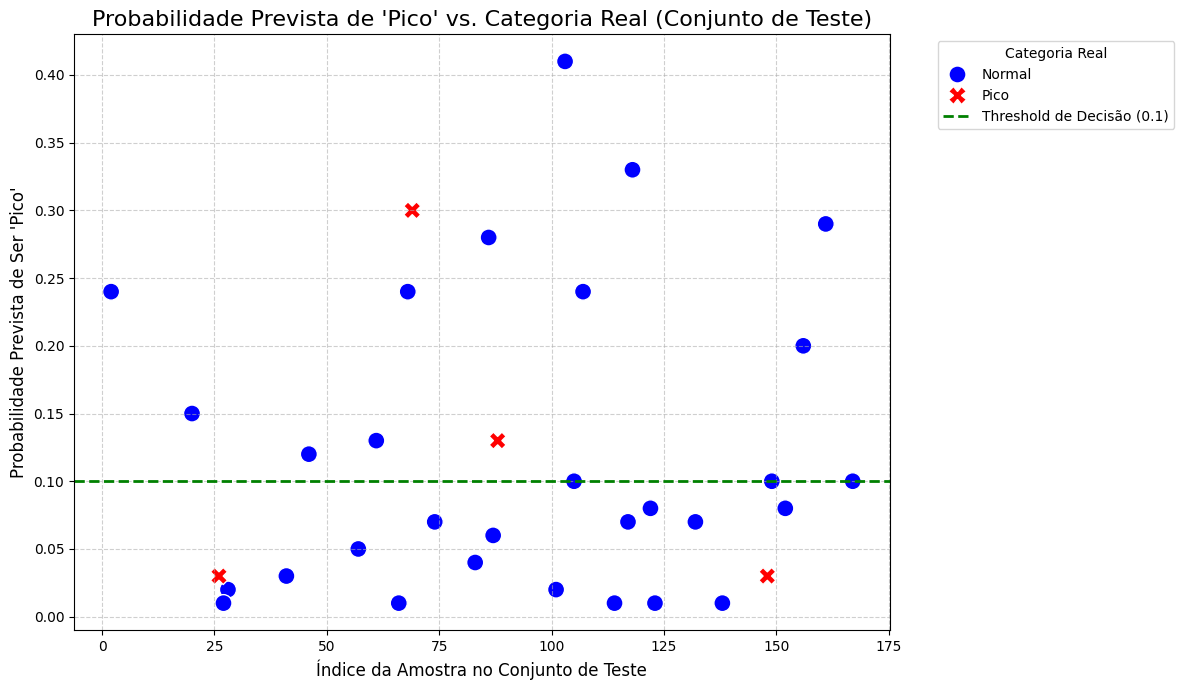

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Import numpy

# Assumindo que X_test, y_test, rf_classifier e custom_threshold (0.1) estão definidos do código anterior
# Se você estiver executando este trecho separadamente, certifique-se de que esses objetos existam.

# Re-gerar y_pred_rf e probabilities caso não estejam mais na memória ativa
if 'rf_classifier' not in locals():
    print("rf_classifier não encontrado. Por favor, execute as células de treinamento do modelo novamente.")
    # Exemplo dummy se rf_classifier não existe, APENAS PARA TESTE. REMOVER EM USO REAL
    # rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # rf_classifier.fit(X_train, y_train) # Assumindo X_train, y_train existem

y_pred_rf = rf_classifier.predict(X_test)

if 'Pico' in rf_classifier.classes_:
    pico_class_index = list(rf_classifier.classes_).index('Pico')
    probabilities = rf_classifier.predict_proba(X_test)[:, pico_class_index]
else:
    print("A classe 'Pico' não foi encontrada nas classes do modelo.")
    probabilities = np.zeros(len(X_test)) # Array de zeros se 'Pico' não for encontrado

# Criar o DataFrame de resultados novamente
results_df = pd.DataFrame({
    'Actual_Category': y_test,
    'Predicted_Probability_Pico': probabilities,
    'Predicted_Category_RF': y_pred_rf
}, index=X_test.index)

custom_threshold = 0.1 # Nosso threshold definido anteriormente

plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=results_df.index, # Usamos o índice para espalhar os pontos ao longo do eixo X
    y='Predicted_Probability_Pico',
    hue='Actual_Category', # Colore os pontos pela categoria real
    style='Actual_Category', # Adiciona estilo diferente para as categorias
    s=150, # Tamanho dos pontos
    data=results_df,
    palette={'Normal': 'blue', 'Pico': 'red'} # Cores personalizadas
)

# Adicionar o limiar como uma linha horizontal
plt.axhline(y=custom_threshold, color='green', linestyle='--', linewidth=2, label=f'Threshold de Decisão ({custom_threshold})')

plt.title("Probabilidade Prevista de 'Pico' vs. Categoria Real (Conjunto de Teste)", fontsize=16)
plt.xlabel("Índice da Amostra no Conjunto de Teste", fontsize=12)
plt.ylabel("Probabilidade Prevista de Ser 'Pico'", fontsize=12)
plt.legend(title="Categoria Real", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1852458650.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_campaigns_scheduled', y='order_count', data=campaign_impact_scheduled, palette='viridis')


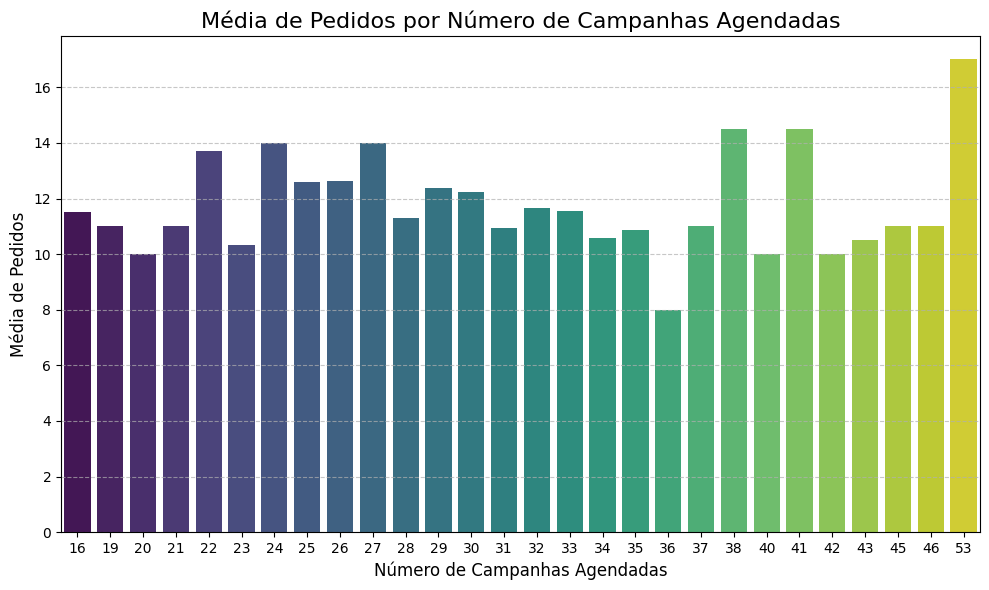

In [54]:
# Assumindo que df_demand_enriched está definido do código anterior.
# Se você estiver executando este trecho separadamente, certifique-se de que df_demand_enriched exista.

# Agrupar por número de campanhas agendadas e calcular a média de pedidos
campaign_impact_scheduled = df_demand_enriched.groupby('num_campaigns_scheduled')['order_count'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='num_campaigns_scheduled', y='order_count', data=campaign_impact_scheduled, palette='viridis')
plt.title("Média de Pedidos por Número de Campanhas Agendadas", fontsize=16)
plt.xlabel("Número de Campanhas Agendadas", fontsize=12)
plt.ylabel("Média de Pedidos", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Você pode repetir para 'num_campaigns_sent' se desejar
# campaign_impact_sent = df_demand_enriched.groupby('num_campaigns_sent')['order_count'].mean().reset_index()
# plt.figure(figsize=(10, 6))
# sns.barplot(x='num_campaigns_sent', y='order_count', data=campaign_impact_sent, palette='plasma')
# plt.title("Média de Pedidos por Número de Campanhas Enviadas", fontsize=16)
# plt.xlabel("Número de Campanhas Enviadas", fontsize=12)
# plt.ylabel("Média de Pedidos", fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

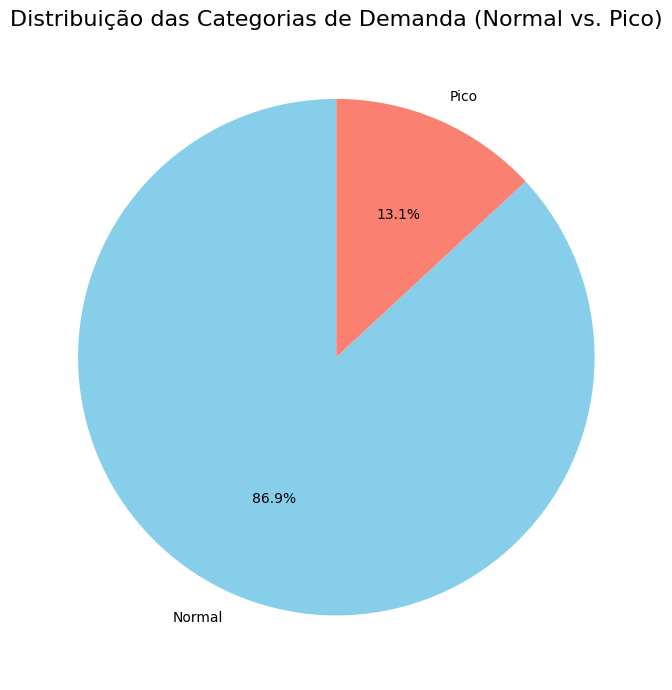

In [55]:
plt.figure(figsize=(7, 7))
df_demand_enriched['demand_category_binary'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title("Distribuição das Categorias de Demanda (Normal vs. Pico)", fontsize=16)
plt.ylabel("")
plt.tight_layout()
plt.show()